In [1]:
import pandas as pd

# Load Excel and select the "Stunting Proportion (Model)" sheet
file_path = "JME_Country_Estimates_May_2023.xlsx"
xls = pd.ExcelFile(file_path)
df = xls.parse("Stunting Proportion (Model)")

# Step 1: Filter to only "Point Estimate"
df = df[df["Estimate"] == "Point Estimate"]

# Step 2: Drop unnecessary columns
df = df.drop(columns=["Note", "Indicator", "Measure", "Estimate"])

# Step 3: Replace "-" with NaN and convert year columns to numeric
df = df.replace("-", pd.NA)

# Convert year columns (2000–2022) to float
year_columns = df.columns[2:]  # Skip 'ISO code' and 'Country and areas'
df[year_columns] = df[year_columns].apply(pd.to_numeric, errors="coerce")

# Step 4: Reshape from wide to long format
df_long = df.melt(id_vars=["ISO code", "Country and areas"], 
                  var_name="Year", 
                  value_name="Stunting (%)")

# Step 5: Rename columns for clarity
df_long.rename(columns={
    "Country and areas": "Country",
    "ISO code": "ISO_Code"
}, inplace=True)

# Optional: Drop rows with missing stunting values
df_long = df_long.dropna(subset=["Stunting (%)"])

# Step 6: Convert year to integer
df_long["Year"] = df_long["Year"].astype(int)

# Show cleaned data
print(df_long.head())

  ISO_Code      Country  Year  Stunting (%)
0      AFG  Afghanistan  2000          54.9
1      ALB      Albania  2000          29.5
2      DZA      Algeria  2000          22.3
4      AGO       Angola  2000          46.5
7      ARG    Argentina  2000           9.4


In [2]:
import pandas as pd

# === STEP 1: Load and clean stunting data (JME Excel) ===
jme_file_path = "JME_Country_Estimates_May_2023.xlsx"
xls = pd.ExcelFile(jme_file_path)
stunting_df = xls.parse("Stunting Proportion (Model)")

# Filter to only Point Estimates
stunting_df = stunting_df[stunting_df["Estimate"] == "Point Estimate"]

# Drop unnecessary columns
stunting_df = stunting_df.drop(columns=["Note", "Indicator", "Measure", "Estimate"])

# Replace '-' with NaN and convert to numeric
stunting_df = stunting_df.replace("-", pd.NA)
year_columns = stunting_df.columns[2:]
stunting_df[year_columns] = stunting_df[year_columns].apply(pd.to_numeric, errors="coerce")

# Reshape to long format
stunting_long = stunting_df.melt(id_vars=["ISO code", "Country and areas"],
                                 var_name="Year", value_name="Stunting (%)")

# Rename columns
stunting_long.rename(columns={
    "Country and areas": "Country",
    "ISO code": "ISO_Code"
}, inplace=True)

# Drop missing values and convert year to int
stunting_long.dropna(subset=["Stunting (%)"], inplace=True)
stunting_long["Year"] = stunting_long["Year"].astype(int)

# === STEP 2: Load and clean FAOSTAT food price data ===
faostat_file_path = "FAOSTAT_data_en_6-26-2025.csv"
faostat_df = pd.read_csv(faostat_file_path)

# Drop rows with missing food price
faostat_df = faostat_df.dropna(subset=["Value"])

# Group to get yearly average food price index
faostat_yearly = faostat_df.groupby(["Area", "Year"], as_index=False)["Value"].mean()

# Rename columns
faostat_yearly.rename(columns={"Area": "Country", "Value": "Avg_Food_Price_Index"}, inplace=True)

# === STEP 3: Merge both datasets ===
merged_df = pd.merge(stunting_long, faostat_yearly, on=["Country", "Year"], how="inner")

# === STEP 4 (Optional): Save merged dataset ===
merged_df.to_csv("Merged_Stunting_FoodPrice.csv", index=False)

# Show result
print(merged_df.head())

  ISO_Code      Country  Year  Stunting (%)  Avg_Food_Price_Index
0      AFG  Afghanistan  2000          54.9             22.516465
1      ALB      Albania  2000          29.5             62.191227
2      DZA      Algeria  2000          22.3             53.102089
3      AGO       Angola  2000          46.5              1.756858
4      ARG    Argentina  2000           9.4             21.294479


INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3374 entries, 0 to 3373
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ISO_Code              3374 non-null   object 
 1   Country               3374 non-null   object 
 2   Year                  3374 non-null   int64  
 3   Stunting (%)          3374 non-null   float64
 4   Avg_Food_Price_Index  3374 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 131.9+ KB
None

DESCRIPTION:
              Year  Stunting (%)  Avg_Food_Price_Index
count  3374.000000   3374.000000          3.374000e+03
mean   2010.994665     21.552282          1.029588e+08
std       6.610862     14.619158          4.557810e+09
min    2000.000000      0.900000          1.211820e+00
25%    2005.000000      8.500000          4.544282e+01
50%    2011.000000     19.000000          6.173787e+01
75%    2017.000000     32.600000          7.008025e+01
max    2

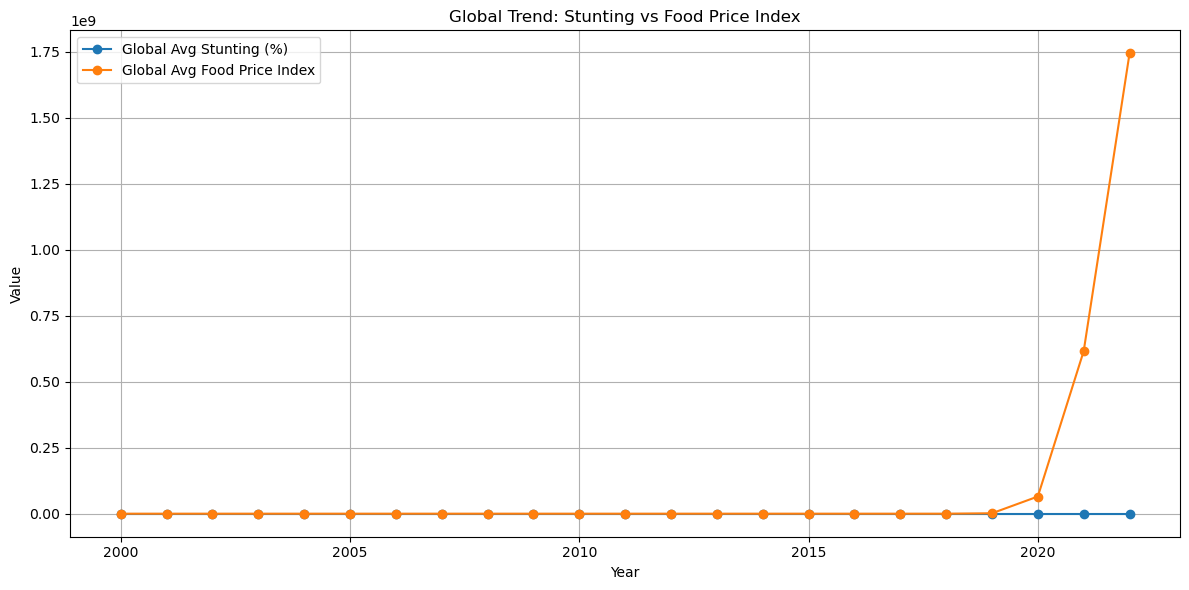

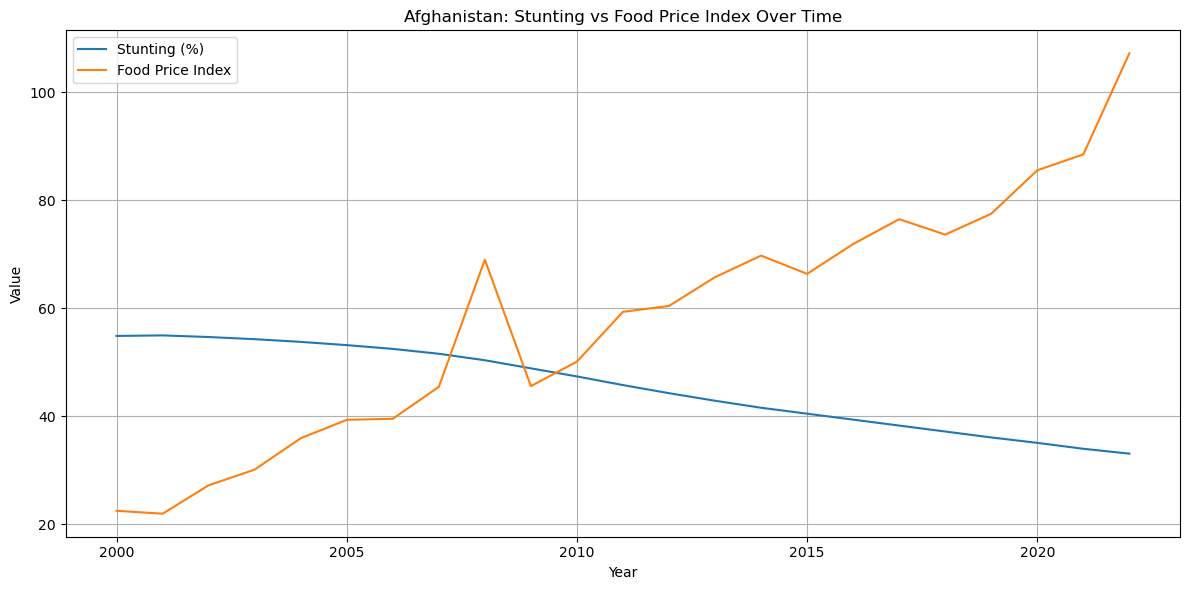

/var/folders/k6/023vhlcn73g6xvvdr1pcsqkm0000gn/T/ipykernel_1428/1578282701.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_countries, x="Stunting (%)", y="Country", palette="Reds_r")


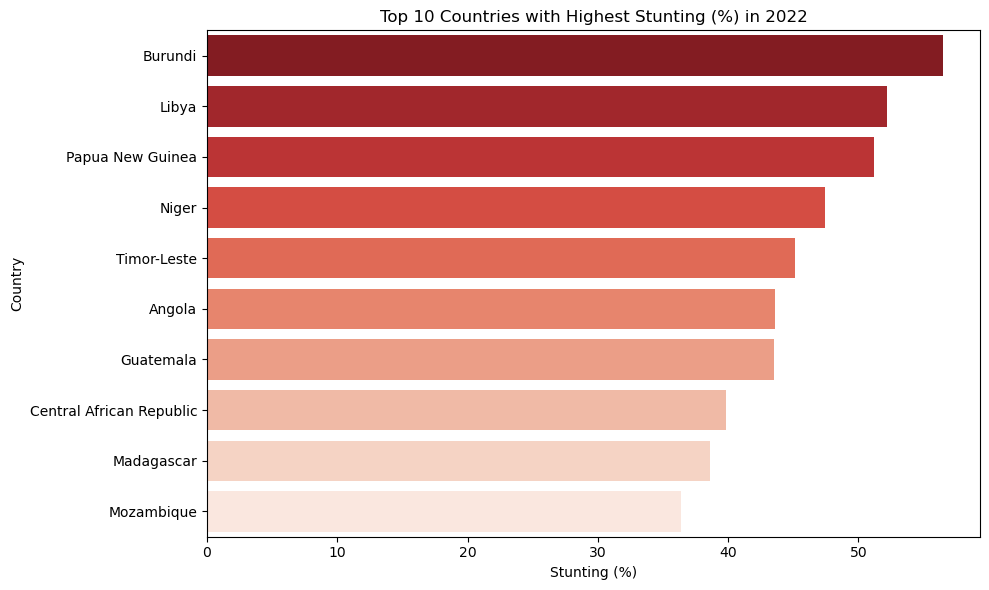

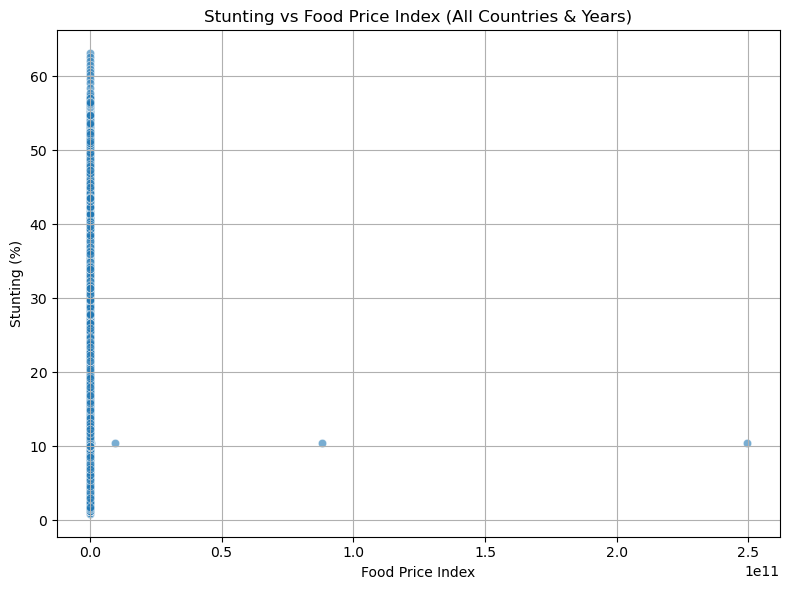

Pearson correlation: -0.02, p-value: 0.3212


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Assuming your merged DataFrame is named 'merged_df'
# Example columns: Country, Year, Stunting (%), Avg_Food_Price_Index

# === Step 1: Dataset Overview ===
print("INFO:")
print(merged_df.info())

print("\nDESCRIPTION:")
print(merged_df.describe())

print("\nUnique Countries:", merged_df["Country"].nunique())
print("Year Range:", merged_df["Year"].min(), "to", merged_df["Year"].max())

# === Step 2: Global Trend Analysis ===
global_avg = merged_df.groupby("Year", as_index=False).agg({
    "Stunting (%)": "mean",
    "Avg_Food_Price_Index": "mean"
})

plt.figure(figsize=(12, 6))
plt.plot(global_avg["Year"], global_avg["Stunting (%)"], label="Global Avg Stunting (%)", marker='o')
plt.plot(global_avg["Year"], global_avg["Avg_Food_Price_Index"], label="Global Avg Food Price Index", marker='o')
plt.title("Global Trend: Stunting vs Food Price Index")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 3: Country-Level Trend ===
country_name = "Afghanistan"  # Change to any other country
country_df = merged_df[merged_df["Country"] == country_name]

plt.figure(figsize=(12, 6))
sns.lineplot(data=country_df, x="Year", y="Stunting (%)", label="Stunting (%)")
sns.lineplot(data=country_df, x="Year", y="Avg_Food_Price_Index", label="Food Price Index")
plt.title(f"{country_name}: Stunting vs Food Price Index Over Time")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 4: Top Countries with Highest Stunting (latest year) ===
latest_year = merged_df["Year"].max()
top_countries = merged_df[merged_df["Year"] == latest_year].nlargest(10, "Stunting (%)")

plt.figure(figsize=(10, 6))
sns.barplot(data=top_countries, x="Stunting (%)", y="Country", palette="Reds_r")
plt.title(f"Top 10 Countries with Highest Stunting (%) in {latest_year}")
plt.xlabel("Stunting (%)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# === Step 5: Correlation Plot ===
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x="Avg_Food_Price_Index", y="Stunting (%)", alpha=0.6)
plt.title("Stunting vs Food Price Index (All Countries & Years)")
plt.xlabel("Food Price Index")
plt.ylabel("Stunting (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation coefficient
corr, p_value = pearsonr(merged_df["Avg_Food_Price_Index"], merged_df["Stunting (%)"])
print(f"Pearson correlation: {corr:.2f}, p-value: {p_value:.4f}")


In [4]:
# Top 10 stunting countries in the most recent year
latest_year = merged_df["Year"].max()
top_stunting_df = merged_df[merged_df["Year"] == latest_year].nlargest(10, "Stunting (%)")

# Select relevant columns for inspection
top_stunting_df = top_stunting_df[["Country", "Stunting (%)", "Avg_Food_Price_Index"]]

# Sort by stunting (%) again just in case
top_stunting_df = top_stunting_df.sort_values("Stunting (%)", ascending=False)

print(top_stunting_df)


                       Country  Stunting (%)  Avg_Food_Price_Index
3254                   Burundi          56.5            121.486378
3304                     Libya          52.2            137.300092
3329          Papua New Guinea          51.2             91.986386
3323                     Niger          47.4             82.242652
3358               Timor-Leste          45.1             79.544992
3234                    Angola          43.6            316.797215
3281                 Guatemala          43.5            104.327475
3258  Central African Republic          39.8            127.806043
3306                Madagascar          38.6            110.581328
3317                Mozambique          36.4            131.532777


In [5]:
# === STEP 1: Import libraries ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === STEP 2: Load merged dataset ===
df = pd.read_csv("Merged_Stunting_FoodPrice.csv")

# === STEP 3: Define features and target ===
X = df[["Avg_Food_Price_Index"]]  # Feature(s)
y = df["Stunting (%)"]            # Target

# === STEP 4: Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === STEP 5: Linear Regression ===
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

# === STEP 6: Random Forest Regressor ===
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# === STEP 7: Evaluate both models ===
def evaluate_model(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Performance:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R² Score: {r2:.2f}")
    print("")

evaluate_model("Linear Regression", y_test, y_pred_lin)
evaluate_model("Random Forest", y_test, y_pred_rf)


Linear Regression Performance:
  RMSE: 14.88
  R² Score: -0.00

Random Forest Performance:
  RMSE: 17.32
  R² Score: -0.36



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [6]:
import pandas as pd

# Load GDP data
gdp_raw = pd.read_csv("API_NY.GDP.PCAP.CD_DS2_en_csv_v2_123534.csv", skiprows=4)

# Filter and reshape
gdp_filtered = gdp_raw[["Country Name", "Country Code"] + [str(y) for y in range(2000, 2023)]]
gdp_long = pd.melt(gdp_filtered,
                   id_vars=["Country Name", "Country Code"],
                   var_name="Year",
                   value_name="GDP_per_capita")
gdp_long["Year"] = gdp_long["Year"].astype(int)
gdp_long.dropna(subset=["GDP_per_capita"], inplace=True)


In [7]:
# Load merged stunting + food price dataset
merged_df = pd.read_csv("Merged_Stunting_FoodPrice.csv")

# Merge with GDP per capita
final_df = pd.merge(
    merged_df,
    gdp_long,
    how="left",
    left_on=["Country", "Year"],
    right_on=["Country Name", "Year"]
)

# Clean up
final_df.drop(columns=["Country Name"], inplace=True)

# Preview merged data
final_df[["Country", "Year", "Stunting (%)", "Avg_Food_Price_Index", "GDP_per_capita"]].head()


,Country,Year,Stunting (%),Avg_Food_Price_Index,GDP_per_capita
0,Afghanistan,2000,54.9,22.516465,174.930991
1,Albania,2000,29.5,62.191227,1126.683340
2,Algeria,2000,22.3,53.102089,1772.928691
3,Angola,2000,46.5,1.756858,563.733796
4,Argentina,2000,9.4,21.294479,7637.014892


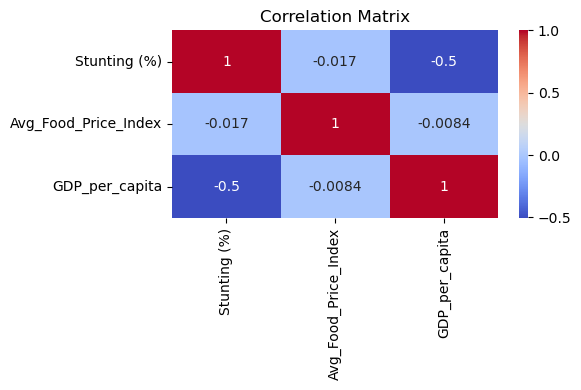

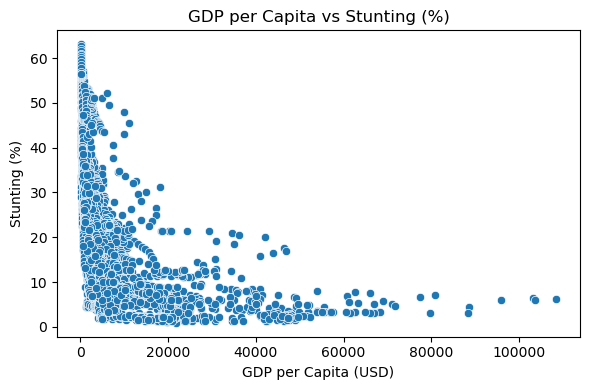

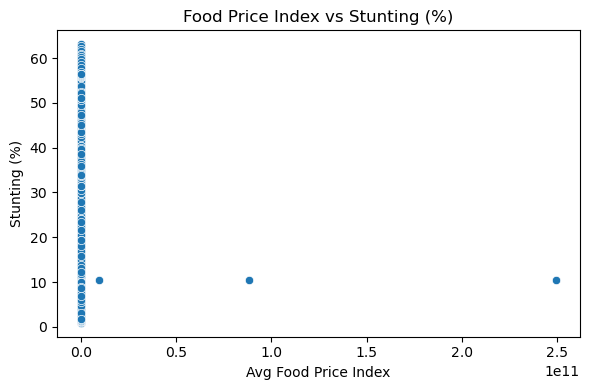

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Correlation Heatmap ===
plt.figure(figsize=(6,4))
sns.heatmap(final_df[["Stunting (%)", "Avg_Food_Price_Index", "GDP_per_capita"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# === Step 2: Scatterplot: GDP vs Stunting ===
plt.figure(figsize=(6,4))
sns.scatterplot(data=final_df, x="GDP_per_capita", y="Stunting (%)")
plt.title("GDP per Capita vs Stunting (%)")
plt.xlabel("GDP per Capita (USD)")
plt.ylabel("Stunting (%)")
plt.tight_layout()
plt.show()

# === Step 3: Scatterplot: Food Price vs Stunting ===
plt.figure(figsize=(6,4))
sns.scatterplot(data=final_df, x="Avg_Food_Price_Index", y="Stunting (%)")
plt.title("Food Price Index vs Stunting (%)")
plt.xlabel("Avg Food Price Index")
plt.ylabel("Stunting (%)")
plt.tight_layout()
plt.show()


Risk_Level
Low     2359
High    1015
Name: count, dtype: int64

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       461
           1       0.70      0.66      0.68       214

    accuracy                           0.80       675
   macro avg       0.77      0.76      0.77       675
weighted avg       0.80      0.80      0.80       675


=== Confusion Matrix ===


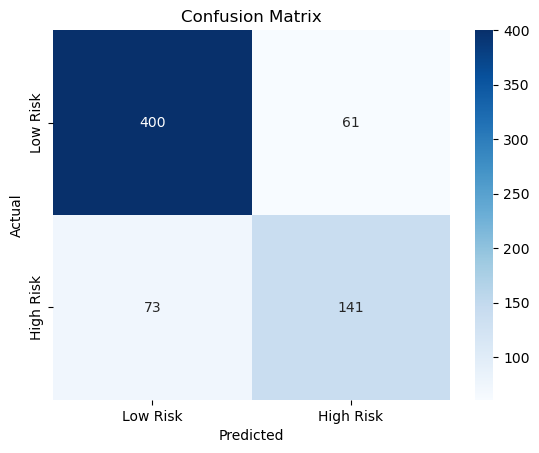

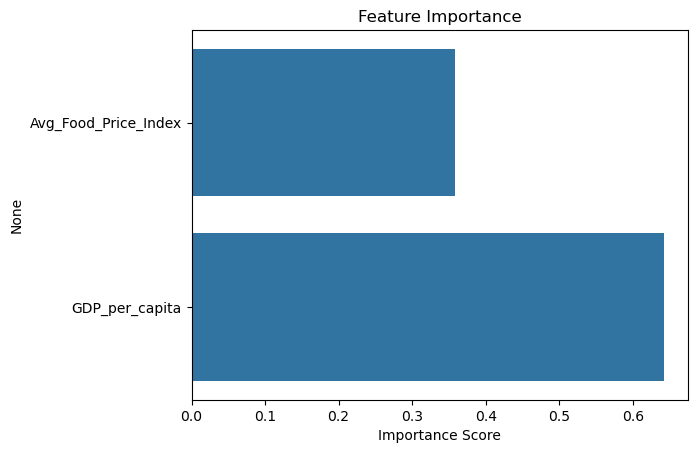

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# STEP 1: Label risk based on Stunting threshold
final_df["Risk_Level"] = final_df["Stunting (%)"].apply(lambda x: "High" if x >= 30 else "Low")
final_df["Risk_Label"] = final_df["Risk_Level"].map({"High": 1, "Low": 0})

# Optional: Check class distribution
print(final_df["Risk_Level"].value_counts())

# STEP 2: Define features and target
X = final_df[["Avg_Food_Price_Index", "GDP_per_capita"]]
y = final_df["Risk_Label"]

# STEP 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP 4: Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# STEP 5: Evaluate performance
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Risk", "High Risk"], yticklabels=["Low Risk", "High Risk"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# STEP 6: Feature Importance
importances = clf.feature_importances_
feature_names = X.columns
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.show()



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       461
           1       0.67      0.72      0.70       214

    accuracy                           0.80       675
   macro avg       0.77      0.78      0.77       675
weighted avg       0.80      0.80      0.80       675



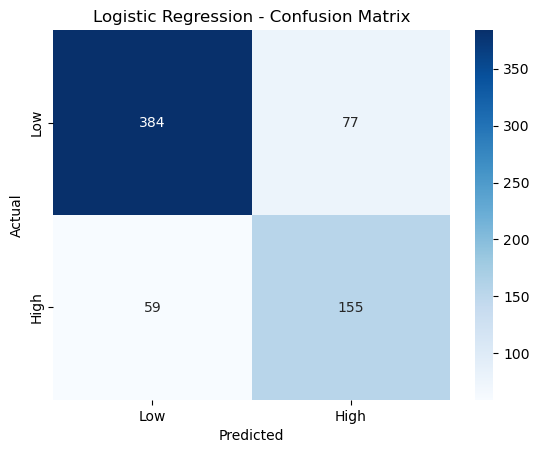


=== Support Vector Machine ===
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       461
           1       0.63      0.74      0.68       214

    accuracy                           0.78       675
   macro avg       0.75      0.77      0.76       675
weighted avg       0.79      0.78      0.78       675



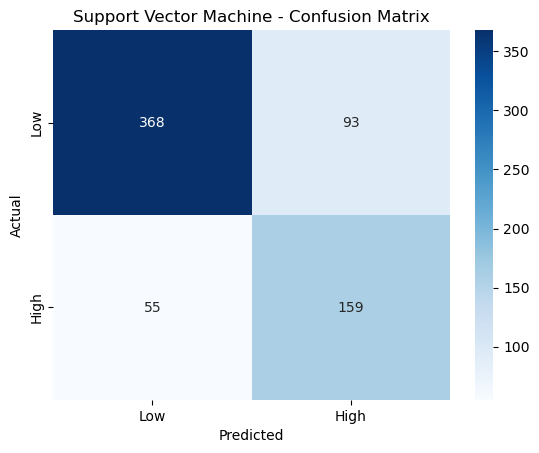


=== K-Nearest Neighbors ===
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       461
           1       0.67      0.66      0.67       214

    accuracy                           0.79       675
   macro avg       0.76      0.76      0.76       675
weighted avg       0.79      0.79      0.79       675



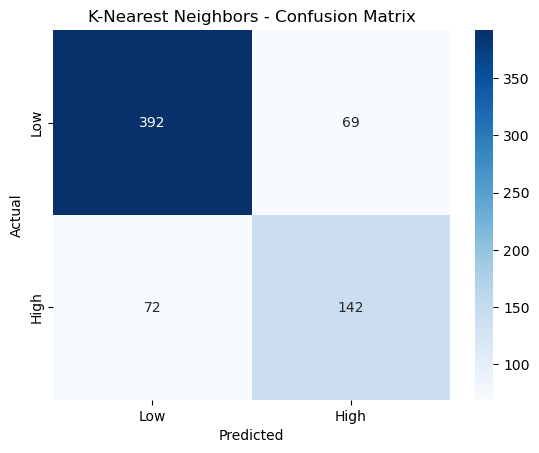


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       461
           1       0.69      0.56      0.62       214

    accuracy                           0.78       675
   macro avg       0.75      0.72      0.73       675
weighted avg       0.77      0.78      0.78       675



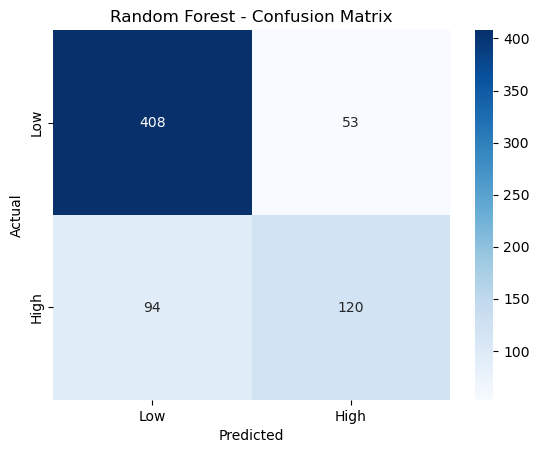

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# STEP 1: Extract features and target
features = ['Avg_Food_Price_Index', 'GDP_per_capita']
X_raw = final_df[features]
y = final_df['Risk_Level'].map({'Low': 0, 'High': 1})

# STEP 2: Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_raw)

# STEP 3: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# STEP 4: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# STEP 5: Define models to compare
models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# STEP 6: Train and evaluate each model
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "High"], yticklabels=["Low", "High"])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Best Params: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}

=== Tuned Logistic Regression ===
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       461
           1       0.67      0.72      0.70       214

    accuracy                           0.80       675
   macro avg       0.77      0.78      0.77       675
weighted avg       0.80      0.80      0.80       675



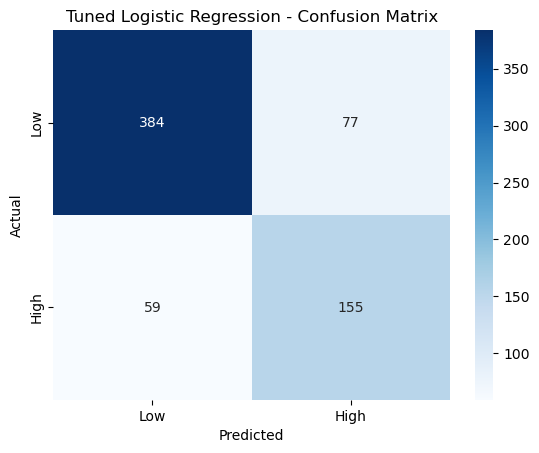

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline: Imputer → Scaler → Logistic Regression
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])

# Grid search params for logistic regression
param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear'],  # 'liblinear' supports both L1 and L2
}

# Grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)

# ✅ This is the key fix:
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)

# Predict and evaluate
y_pred_best = best_model.predict(X_test)
print("\n=== Tuned Logistic Regression ===")
print(classification_report(y_test, y_pred_best))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.title("Tuned Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/var/folders/k6/023vhlcn73g6xvvdr1pcsqkm0000gn/T/ipykernel_1428/3351151183.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='coolwarm')


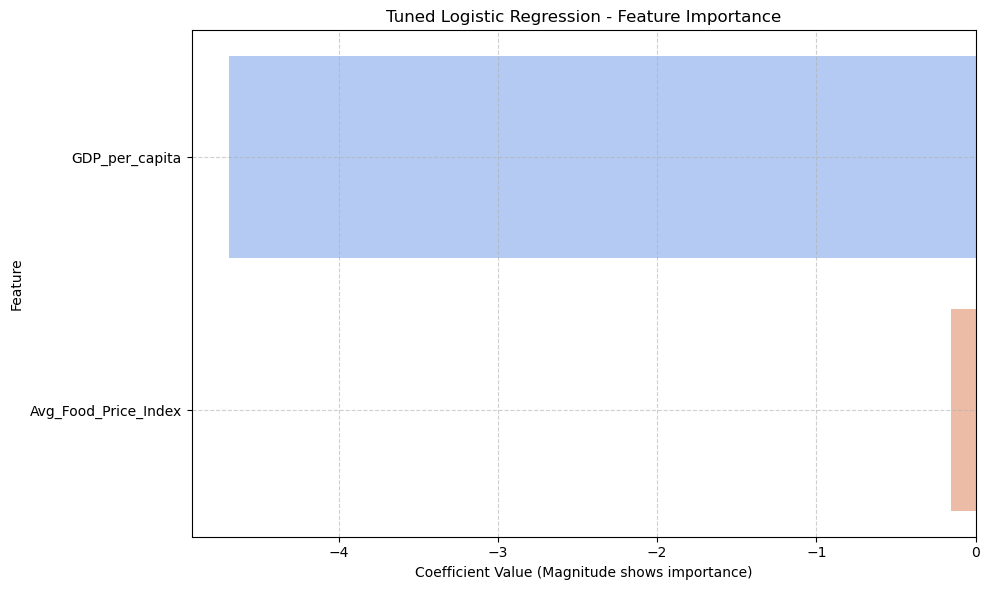

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assign best estimator from grid search
best_log_reg = grid_search.best_estimator_

# Ensure you use the original feature names before scaling
feature_names = X.columns  # X must be the unscaled DataFrame with original column names
coefficients = best_log_reg.named_steps['model'].coef_[0]

# Create DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
}).sort_values(by='Importance', key=abs, ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='coolwarm')
plt.title('Tuned Logistic Regression - Feature Importance')
plt.xlabel('Coefficient Value (Magnitude shows importance)')
plt.ylabel('Feature')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [26]:
# Export cleaned dataset to CSV
final_df.to_csv("final_data.csv", index=False)

In [28]:
import joblib


joblib.dump(best_log_reg, "log_reg_model.pkl")

print("Model saved as log_reg_model.pkl")


Model saved as log_reg_model.pkl
